# Example notebook for generating masks for metasurfaces with pyMOE 

The following notebook exemplifies how to make a metasurface from a 2D phase mask - while it is for a Fresnel phase mask, in general any 2D phase can be used to obtain the metasurface mask. 

In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}


import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

In [2]:
import pyMOE as moe 

In [3]:
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt 
import gdspy

from scipy.constants import micro, nano, milli

import pya
from pyMOE.gds_klops import rotate_layout

<IPython.core.display.Javascript object>


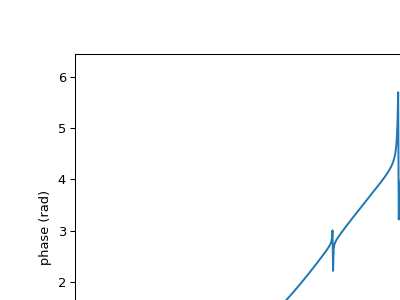

(0.0, 0.445)

In [4]:
###the curve of diameter of cylinder vs lattice const is imported  (here from RCWA calc)

dvar_cut = np.genfromtxt("dvar_638nm_p445nm.txt", delimiter=",")  
phas_cut = np.genfromtxt("phaserad_638nm_p445nm.txt", delimiter=",")  

#the periodicity 
p=0.445 # in um 

fig = plt.figure() 
plt.plot(dvar_cut, phas_cut)
plt.xlabel('diameter ($\mu$m)')
plt.ylabel('phase (rad)')
plt.xlim([0,p])
#np.max(dvar_cut)

In [5]:
from scipy import interpolate

#function that interpolates the phase difference curve 
#given a certain phase, will give us the diameter of the cylinders
func = interpolate.interp1d(phas_cut,dvar_cut, fill_value="extrapolate")

<IPython.core.display.Javascript object>


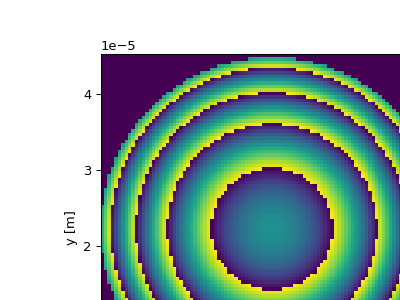

<IPython.core.display.Javascript object>


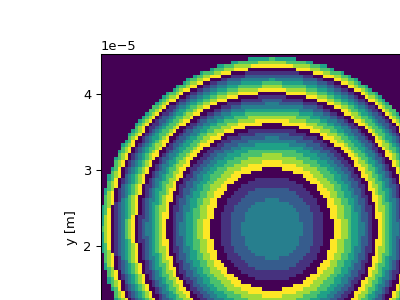

[Create Polygons]
Elapsed: 0:00:00.264018
Merging layer 0 of 7 with 3381 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.500118
Merging layer 1 of 7 with 978 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.509036
Merging layer 2 of 7 with 998 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.439035
Merging layer 3 of 7 with 998 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.338025
Merging layer 4 of 7 with 888 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.333025
Merging layer 5 of 7 with 1010 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.370029
Merging layer 6 of 7 with 960 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.365024
Merging layer 7 of 7 with 988 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.456071
[Total time converting to GDS]
Elapsed: 0:00:04.581382
Saved fresnel_phase_mask.gds


In [6]:
foc = 100 # focal distance in um 
lda = 0.6328 #wavelength in um 
xsiz = 45 #um
ysiz = 45 #um
n = 8  # number of gray levels  
gdsname = 'fresnel_phase_mask.gds' # name of gds file

#calculation for the number of pixels using the size in x and the periodicity
npix = int(np.round(xsiz/p))

#obtain the phase profile of a fresnel phase mask 
#fresarray_rad= moe.gen.fresnel_phase_mask(npix, foc, lda, xsiz, ysiz, n, filename=gdsname, plotting=True)

# Create empty mask
aperture = moe.generate.create_empty_aperture(0, xsiz*micro, npix, 0, ysiz*micro, npix,)

center = (xsiz*micro/2-p*micro/2, ysiz*micro/2-p*micro/2)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture, foc * micro, lda * micro, radius=xsiz/2*micro, center = center)
moe.plotting.plot_aperture(mask, )

mask.discretize(n)
moe.plotting.plot_aperture(mask)

gdsmask = moe.GDSMask(mask, verbose=False)

# Create layout and merge polygons together
gdsmask.create_layout(mode = "raster", merge=True) # or mode ="contour"
gdsmask.write_gds(gdsname)

In [7]:
fresarray_rad = mask.aperture 
fresarray_rad.shape

(101, 101)

In [8]:
fresarray_rad

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
###transform the phase map into [0, 2*pi]
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas = fresarray_rad 

#transform the phase map into a map of the pillar diameters 
dvars = func(fphas)
dvars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>


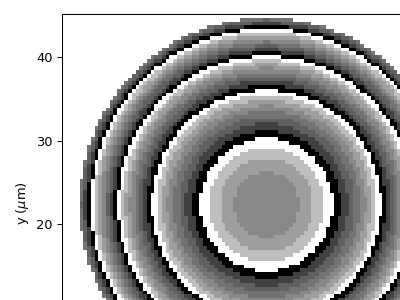

In [10]:
###Let's represent the map of the diameter of the cylinders
#clip the matrix of values within a range 
dvarx = np.clip(dvars,0,np.max(dvar_cut) )

#create the vectors for xsiz and ysiz, with npix 
xc1 = np.linspace(0, xsiz, npix)
yc1 = np.linspace(0, ysiz, npix)
(xc, yc) = np.meshgrid(xc1,yc1)
    
plt.figure()
plt.axis('equal')
plt.pcolormesh(xc,yc,dvarx, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()

Pillar metasurface
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:00
Building meta-elements in layer 1:
Progress: [####################] 100.0%
Elapsed: 0:00:00.129008
Building meta-elements in layer 2:
Progress: [####################] 100.0%
Elapsed: 0:00:00.130009
Building meta-elements in layer 3:
Progress: [####################] 100.0%
Elapsed: 0:00:00.128010
Building meta-elements in layer 4:
Progress: [####################] 100.0%
Elapsed: 0:00:00.118008
Building meta-elements in layer 5:
Progress: [####################] 100.0%
Elapsed: 0:00:00.118007
Building meta-elements in layer 6:
Progress: [####################] 100.0%
Elapsed: 0:00:00.121008
Building meta-elements in layer 7:
Progress: [####################] 100.0%
Elapsed: 0:00:00.132009
Elapsed: 0:00:00.887066

 Saved the metasurface mask with 6820 meta-elements in the file fresnel_metasurface_pillars.gds


<IPython.core.display.Javascript object>


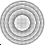

7 polygons found...
Layers: [0]
Datatypes: [0]
xmax is 44.20124611998187
ymax is 44.20095421155875
xmin is -0.5010000000000001
ymin is -0.5000000000000001
Imported file fresnel_metasurface_pillars_instance_circle.gds and exported into fresnel_metasurface_pillars.bmp with size 44 x 44 pixels.


In [13]:
###Transform the phase profile into a metasurface mask 
import pyMOE.metas  as metas

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p 
aperture_vals = mask.aperture
diam_mat = np.unique(dvarx) 
topcellname = "TOP" #name of the gds cell 
outfile = "fresnel_metasurface_pillars.gds"

moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile, scaling= diam_mat, \
                       gdspyelements='pillar', verbose=False, grid='square')

## Selection of diameters + phases 

The previous example considers all the values of the 2D phase map. However, due to the extrapolation within the interpolation function there might be some outlier values for the diameters of the pillars. 

For this we can select a limited number of points and re-design the metasurface with this selection. 


In [12]:
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas = fresarray_rad 
#print(fphas)

#bins array, with n divisions, for the selection of points
#can be used in conjunction with the generate mask with exact selection of phase contours  - see Generate_masks.ipynb
binarray = np.linspace(0,2*np.pi,n+1)

#digitize the phase into the bins that we want 
#attention that the digitize function gives the INDEX of the value in the binarray 
newphas = np.digitize(fphas, bins = binarray, right=True)

#initialize the  2D array of diameters 
diam_mat= fphas

#To get the correspondent phase and also the diameter we do
for i, iv in enumerate(newphas): 
    for j, jv in enumerate(newphas[i,:]): 
        #get the phase corresponding to the digitization
        dphas = binarray[newphas[i,j] ] 
        #get the diameter from the interpolation function 
        #we clip to avoid the extrapolation at borders 
        diam_mat[i,j] = np.clip(func(dphas ) , 0, p)
        
#check how many levels we actually have
print(np.shape(np.unique(diam_mat)))

(8,)


<IPython.core.display.Javascript object>


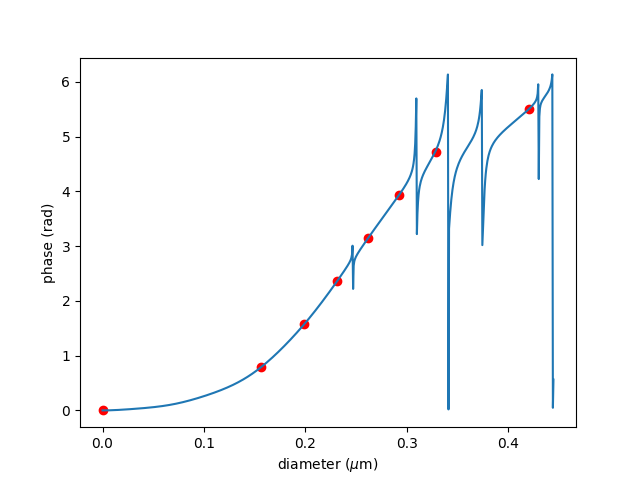

Text(0, 0.5, 'phase (rad)')

In [13]:
#Let's check the selection of phase and diameters 
diamsel = np.unique(diam_mat) 
phasesel = binarray[np.unique(newphas) ]

#print(diamsel.shape)
#print(phasesel.shape)

fig = plt.figure() 
plt.plot(dvar_cut, phas_cut)
plt.scatter(diamsel, phasesel, color='red')
plt.xlabel('diameter ($\mu$m)')
plt.ylabel('phase (rad)')

The number of levels after printing is 8.


<IPython.core.display.Javascript object>


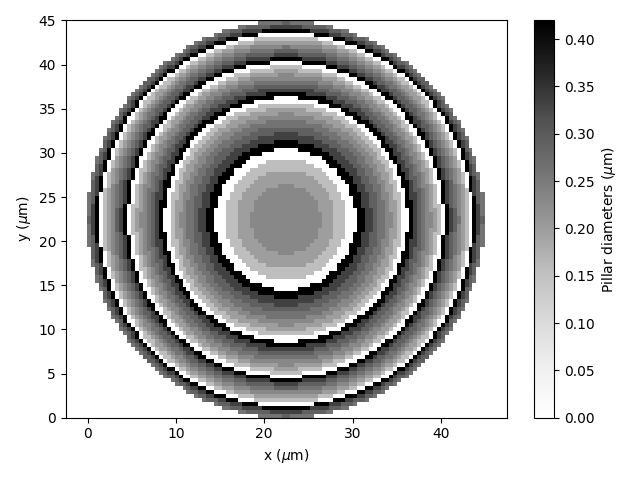

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [14]:
###Let's inspect the map of the diameter of the cylinders

#clip the matrix of values within a range  
#dvarx = np.clip(diam_mat,0,p*0.9 )

#when clipping, we might be cutting some levels (so, the actual nr of levels is)
print("The number of levels after printing is " +str(len(np.unique(dvarx))) + ".")


#create the vectors for xsiz and ysiz, with npix 
xc1 = np.linspace(0, xsiz, npix)
yc1 = np.linspace(0, ysiz, npix)
(xc, yc) = np.meshgrid(xc1,yc1)
    
plt.figure()
plt.axis('equal')
plt.pcolormesh(xc,yc,dvarx, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()

In [15]:
###Transform the square grid phase profile into a metasurface mask using instatiation of self-define pillar element

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p 
topcellname = "TOP" #name of the gds cell 
outfilen  = "fresnel_metasurface_pillars_instance.gds"
aperture_vals = mask.aperture
diam_mat = np.unique(dvarx) 

moe.metas.metasurface_from_phase_instances (xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfilen, \
                                      infile=None, verbose=False, rotation=None, scaling=diam_mat, grid='square',\
                                      mindim = 0.05, smallerdim =0, tempfile="temp.gds")

Pillar metasurface
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:00
Progress: [####################] 100.0%
So far 0 elements and counting.
Building meta-elements in layer 1:
Elapsed: 0:00:00.039003
Progress: [####################] 100.0%
So far 978 elements and counting.
Building meta-elements in layer 2:
Elapsed: 0:00:00.047005
Progress: [####################] 100.0%
So far 1976 elements and counting.
Building meta-elements in layer 3:
Elapsed: 0:00:00.047010
Progress: [####################] 100.0%
So far 2974 elements and counting.
Building meta-elements in layer 4:
Elapsed: 0:00:00.046004
Progress: [####################] 100.0%
So far 3862 elements and counting.
Building meta-elements in layer 5:
Elapsed: 0:00:00.051005
Progress: [####################] 100.0%
So far 4872 elements and counting.
Building meta-elements in layer 6:
Elapsed: 0:00:00.049003
Progress: [####################] 100.0%
So far 5832 elements and counting.
Buildin

In [16]:
###Transform the phase profile into a metasurface mask using instatiation with input meta-element file "circle.gds"

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p  
topcellname = "TOP" #name of the gds cell 
outfilen  = "fresnel_metasurface_pillars_instance_circle.gds"
aperture_vals = mask.aperture
diam_mat = np.unique(dvarx) 

moe.metas.metasurface_from_phase_instances (xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfilen, infile="circle.gds",\
                                  verbose=False, rotation=None, scaling=diam_mat, grid='square',\
                                  mindim = 0.05, smallerdim =0, tempfile="tempcircle.gds")


Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:00
Progress: [####################] 100.0%
So far 0 elements and counting.
Building meta-elements in layer 1:
Rotated circle.gds by 0.0 degrees. Saved in tempcircle.gds
Elapsed: 0:00:00.039005
Progress: [####################] 100.0%
So far 978 elements and counting.
Building meta-elements in layer 2:
Rotated circle.gds by 0.0 degrees. Saved in tempcircle.gds
Elapsed: 0:00:00.053006
Progress: [####################] 100.0%
So far 1976 elements and counting.
Building meta-elements in layer 3:
Rotated circle.gds by 0.0 degrees. Saved in tempcircle.gds
Elapsed: 0:00:00.056005
Progress: [####################] 100.0%
So far 2974 elements and counting.
Building meta-elements in layer 4:
Rotated circle.gds by 0.0 degrees. Saved in tempcircle.gds
Elapsed: 0:00:00.048004
Progress: [####################] 100.0%
So far 3862 elements and counting.
Building meta-elements in layer 5:
Rotated circle.gds by 0

<IPython.core.display.Javascript object>


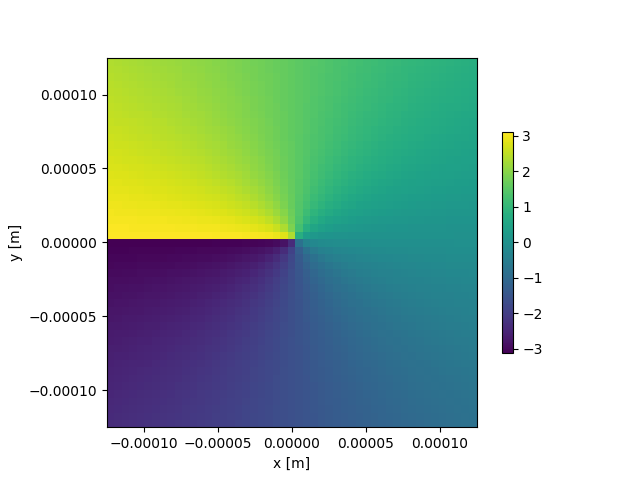

../..\pyMOE\plotting.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(aperture.x/scale_factor, aperture.y/scale_factor, aperture.aperture,)


<IPython.core.display.Javascript object>


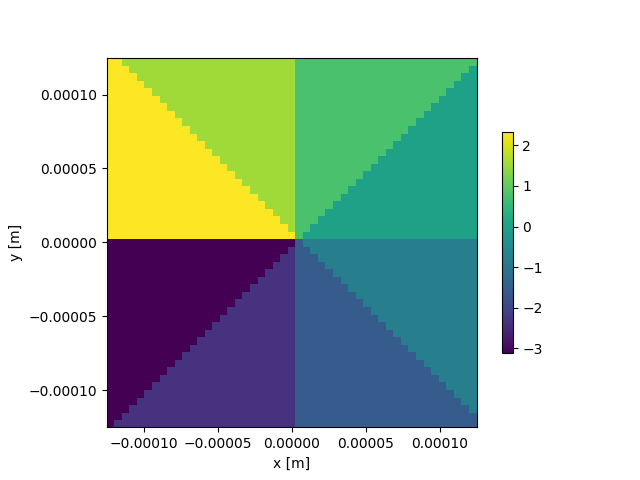

(50, 50)

In [17]:
### Example with a spiral complex phase function 

p = 5 #periodicity between pillars in um 
pixelx = p 
pixely = p 


#attention, make sure to have enough pixels 
#npix = 5000  # number of pixels 
xsiz = 250 #x-size 
ysiz = 250 #y-size 
ltop = 1 #topological number

npix = int(np.round(xsiz/p))

#spiral mask is defined as  
#spiral(x,y,x0,y0,ltop)
    
def spiral(x,y,x0,y0,L):
    """
    returns a spiral COMPLEX PHASE with input meshgrid (x,y) with center at (x0,y0)
    x = x array from meshgrid 
    y = y array from meshgrid 
    x0 = x-coordinate of center of the lens 
    y0 = y-coordinate of center of the lens
    L = topological charge 
    """

    theta = np.arctan2((y-y0),(x-x0))
    sp = np.exp(1.0j*L*theta)
    return sp
    
n =8 # number of gray levels 

center = (0, 0)

aperture = moe.generate.create_empty_aperture(-xsiz/2*micro, xsiz/2*micro, npix, -ysiz/2*micro, ysiz/2*micro, npix,)
mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.spiral, center=center, L=ltop)
moe.plotting.plot_aperture(mask)

mask.discretize(n)
moe.plotting.plot_aperture(mask) 

fresarray_rad = mask.aperture 
fresarray_rad.shape


In [18]:
###Assuming a linear correspondence between the phase and the rotation angle of each meta element
## Here we define a meta element rotated by the corresponding phase angle 
## Here, e.g. rotation array is defined as an array between 0 and 2*pi, but any rotation array can be in principle applied

topcellname = "TOP" #name of the gds cell 
outfile  = "fresnel_metasurface_rect_rotations.gds"
aperture_vals = fresarray_rad
rect = gdspy.Rectangle((-0.5, -2), (0.5, 2))
rotation_array = np.arange(0, 2*np.pi, 2*np.pi/len(np.unique(aperture_vals)))

moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile, rotation=rotation_array,\
                       scaling= None, gdspyelements=rect, verbose=False, grid='square')

###And with instances 
outfile2  = "fresnel_metasurface_rect_rotations_instances.gds"
moe.metas.metasurface_from_phase_instances(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile2, gdspyelements=rect, \
                                 infile=None, verbose=False, rotation=rotation_array, scaling=None, grid='square',\
                                 tempfile="tem_inst.gds")


##HEre we also check the hexagonal grid, for rotation purposes only 
#-> attention, the function is not being recalculated at the hexagonal grid points, but for precise calculation T SHOULD!!
topcellname = "TOP" #name of the gds cell 
outfile  = "fresnel_metasurface_rect_rotations_hexagonal.gds"
aperture_vals = fresarray_rad
rect = gdspy.Rectangle((-0.5, -2), (0.5, 2))
rotation_array = np.arange(0, 2*np.pi, 2*np.pi/len(np.unique(aperture_vals)))

moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile, rotation=rotation_array,\
                       scaling= None, gdspyelements=rect, verbose=False, grid='hex')

###And with instances 
outfile2  = "fresnel_metasurface_rect_rotations_hexagonal_instances.gds"
moe.metas.metasurface_from_phase_instances(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile2, gdspyelements=rect, \
                                 infile=None, verbose=False, rotation=rotation_array, scaling=None, grid='hex',\
                                 tempfile="tem_inst.gds")


Custom metasurface
1
Single gdspyelement element
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Progress: [####################] 100.0%
Elapsed: 0:00:00.071284
Building meta-elements in layer 1:
Progress: [####################] 100.0%
Elapsed: 0:00:00.056003
Building meta-elements in layer 2:
Progress: [####################] 100.0%
Elapsed: 0:00:00.056004
Building meta-elements in layer 3:
Progress: [####################] 100.0%
Elapsed: 0:00:00.068007
Building meta-elements in layer 4:
Progress: [####################] 100.0%
Elapsed: 0:00:00.196014
Building meta-elements in layer 5:
Progress: [####################] 100.0%
Elapsed: 0:00:00.219673
Building meta-elements in layer 6:
Progress: [####################] 100.0%
Elapsed: 0:00:00.221855
Building meta-elements in layer 7:
Progress: [####################] 100.0%
Elapsed: 0:00:00.262507
Elapsed: 0:00:01.162867

 Saved the metasurface mask with 2500 meta-elements in the file fresnel_metasurface_rec

<IPython.core.display.Javascript object>


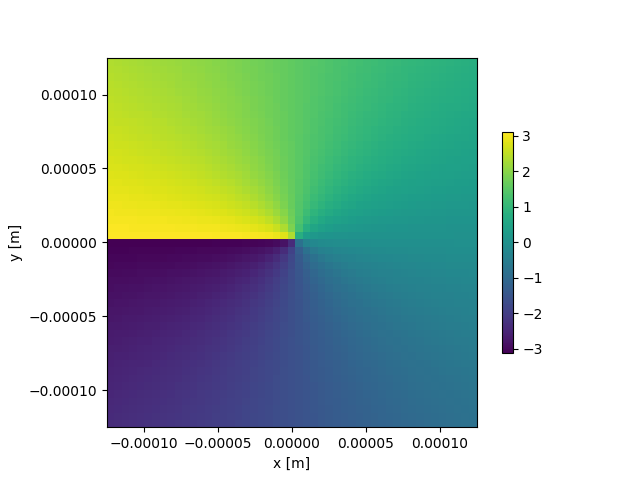

<IPython.core.display.Javascript object>


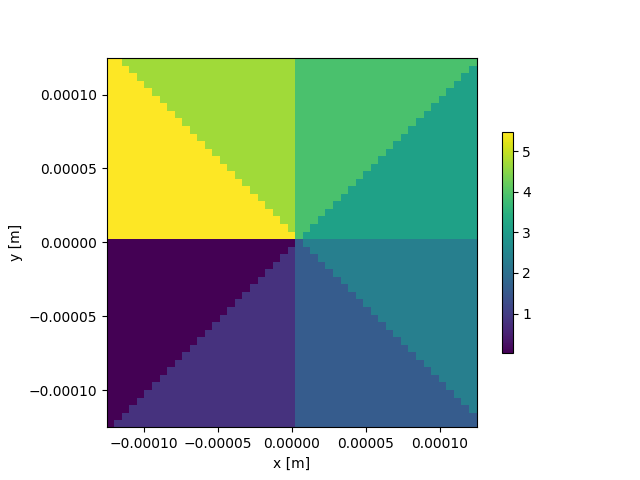

Custom metasurface
8
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Progress: [####################] 100.0%
Elapsed: 0:00:00.071007
Building meta-elements in layer 1:
Progress: [####################] 100.0%
Elapsed: 0:00:00.050001
Building meta-elements in layer 2:
Progress: [####################] 100.0%
Elapsed: 0:00:00.054004
Building meta-elements in layer 3:
Progress: [####################] 100.0%
Elapsed: 0:00:00.058004
Building meta-elements in layer 4:
Progress: [####################] 100.0%
Elapsed: 0:00:00.061003
Building meta-elements in layer 5:
Progress: [####################] 100.0%
Elapsed: 0:00:00.051003
Building meta-elements in layer 6:
Progress: [####################] 100.0%
Elapsed: 0:00:00.063009
Building meta-elements in layer 7:
Progress: [####################] 100.0%
Elapsed: 0:00:00.063004
Elapsed: 0:00:00.479032

 Saved the metasurface mask with 2500 meta-elements in the file spiral_metasurface_yu_capasso.gds
Custom metasurfac

In [19]:
#reconstructing spiral metasurface as in Yu et al. 2011 paper https://www.science.org/doi/10.1126/science.1210713

#construction of meta-element arrays 
def yu_capasso_library_element(cellname, width, length, delta, angle,  nind = None ,save=False ):
    """
    Create Yu et al. meta-element library
    https://www.science.org/doi/10.1126/science.1210713
    
    values from publication 2011: 
    width = 0.22 #um 
    lengtharray = np.array([0.7, 0.9, 1.1, 1.35])  #um
    deltas = np.array([180, 60, 90, 120 ]) #degs
    angles = np.array([-45, 225]) #degs
    
    """  
    lib = gdspy.GdsLibrary()
    gdspy.current_library = gdspy.GdsLibrary()
  
    cell = lib.new_cell(cellname)
        
    rect1 = gdspy.Rectangle((-width/2, 0), (width/2, length))

    rect2 = gdspy.Rectangle((-width/2, 0), (width/2, length))
    rect2 = rect2.rotate(np.radians(delta))
    element = gdspy.boolean(rect1, rect2, "or")
    
    #condition to be improved... 
    if delta==180 or delta==175:
        element = element.rotate(np.radians(angle))

    else: 
        element = element.rotate(np.radians(angle))
        element = element.rotate(np.radians(-delta/2))
    
    if save: 
        cell.add(element)
        name = "element_w"+str(width)+"_l"+str(length)+"_r"+str(angle)+".gds"
        if nind is not None: 
            name = str(nind)+"element_w"+str(width)+"_l"+str(length)+"_r"+str(angle)+".gds"
        lib.write_gds(name)
    
    return element 

cellname = "TOP"

p = 5 #periodicity between elements 
pixelx = p 
pixely = p 

#attention, make sure to have enough pixels 
#npix = 5000  # number of pixels 
xsiz = 250 #x-size 
ysiz = 250 #y-size 
ltop = 1 #topological number

npix = int(np.round(xsiz/p))

n =8 # number of gray levels 

center = (0, 0)

aperture = moe.generate.create_empty_aperture(-xsiz/2*micro, xsiz/2*micro, npix, -ysiz/2*micro, ysiz/2*micro, npix,)
mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.spiral, center=center, L=ltop)
moe.plotting.plot_aperture(mask)

mask.aperture = mask.aperture +np.pi


mask.discretize(n)
moe.plotting.plot_aperture(mask) 

fresarray_rad = mask.aperture

#########################################################################
###make attribution between the phase and element in the yu et al. library 

width = 0.22 #um 
lengtharray = np.array([0.7, 0.9, 1.1, 1.35])  #um
deltas = np.array([180, 60, 90, 120 ]) #degs
angles = np.array([-45, 225]) #degs
elements= [] 

for angle in angles: 
    for il, delta in enumerate(deltas): 
        elements = np.append(yu_capasso_library_element(cellname, width, lengtharray[il], delta, angle, save=True), elements)

        
##organize the meta-elements to match the reported phases in fig 5 
elements = np.flip(elements) 
gdspyelementarray = [elements[6], elements[7], elements[0], elements[1], elements[2], elements[3], elements[4], elements[5]]
        
#Build the metasurface 
topcellname = "TOP" #name of the gds cell 
outfile  = "spiral_metasurface_yu_capasso.gds"
aperture_vals = fresarray_rad
rotation_array = None


moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile, rotation=rotation_array,\
                       scaling= None, gdspyelements=gdspyelementarray, verbose=False, grid='square')

###And with instances 
outfile2  = "spiral_metasurface_yu_capasso_instances.gds"
moe.metas.metasurface_from_phase_instances(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile2,  gdspyelements=gdspyelementarray, \
                                 infile=None, verbose=False, rotation=rotation_array, scaling=None, grid='square',\
                                 tempfile="tem_inst.gds")

<IPython.core.display.Javascript object>


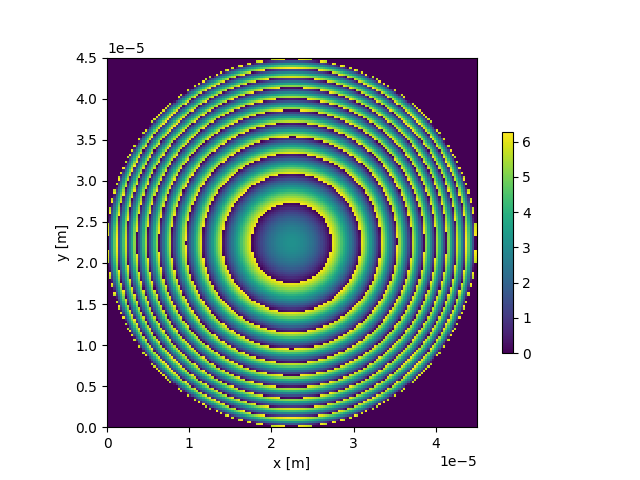

<IPython.core.display.Javascript object>


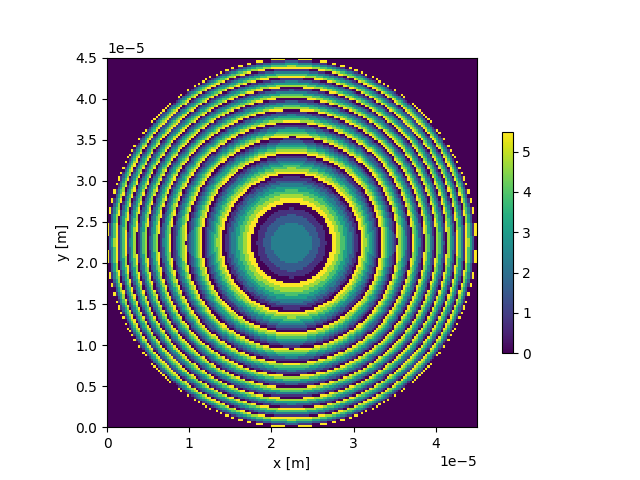

[Create Polygons]
Elapsed: 0:00:00.684720
Merging layer 0 of 7 with 9039 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:05.097772
Merging layer 1 of 7 with 2874 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.109984
Merging layer 2 of 7 with 2727 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.896666
Merging layer 3 of 7 with 2837 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.014077
Merging layer 4 of 7 with 2520 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.817235
Merging layer 5 of 7 with 2526 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.822535
Merging layer 6 of 7 with 2592 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.968173
Merging layer 7 of 7 with 2774 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.044587
[Total time converting to GDS]
Elapsed: 0:00:12.460749
Saved fresnel_phase_mask_triangles.gds


(167, 167)

In [20]:
##reconstructing metalens in paper https://doi.org/10.1126/sciadv.abn5644 
###First with a square grid 

foc = 120 # focal distance in um 
lda = 0.197 #wavelength in um 
xsiz = 45 #um
ysiz = 45 #um
p=0.27
pixelx = p 
pixely = p 
n = 8  # number of gray levels 
gdsname = 'fresnel_phase_mask_triangles.gds' # name of gds file

#calculation for the number of pixels using the size in x and the periodicity
npix = int(np.round(xsiz/p))

#obtain the phase profile of a fresnel phase mask 
#fresarray_rad= moe.gen.fresnel_phase_mask(npix, foc, lda, xsiz, ysiz, n, filename=gdsname, plotting=True)

# Create empty mask
aperture = moe.generate.create_empty_aperture(0, xsiz*micro, npix, 0, ysiz*micro, npix,)

center = (xsiz*micro/2-pixelx*micro/2, ysiz*micro/2-pixely*micro/2)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture, foc * micro, lda * micro, radius=xsiz/2*micro, center = center)
moe.plotting.plot_aperture(mask, )

mask.discretize(n)
moe.plotting.plot_aperture(mask,)



gdsmask = moe.GDSMask(mask, verbose=False)

# Create layout and merge polygons together
gdsmask.create_layout(mode = "raster", merge=True) # or mode ="contour"
gdsmask.write_gds(gdsname)

fresarray_rad = mask.aperture
fresarray_rad.shape

In [21]:
np.unique(fresarray_rad)

array([0.        , 0.7853836 , 1.5707672 , 2.35615079, 3.14153439,
       3.92691799, 4.71230159, 5.49768519])

In [22]:
##Square grid is being used 

aperture_vals = mask.aperture
rotation_array = np.unique(fresarray_rad)
  
topcellname = "TOP" #name of the gds cell 
outfilen  = "fresnel_metasurface_pillars_instance_rotation_triangle.gds"


moe.metas.metasurface_from_phase_instances (xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfilen, infile="triangle.gds",\
                                  verbose=False, rotation=rotation_array, scaling=None, grid='square',\
                                      mindim = 0.05, smallerdim =0, tempfile="temptriangle.gds")


Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Rotated triangle.gds by 0.0 degrees. Saved in temptriangle.gds
Elapsed: 0:00:00.184121
Progress: [####################] 100.0%
So far 9039 elements and counting.
Building meta-elements in layer 1:
Rotated triangle.gds by 44.99916547971991 degrees. Saved in temptriangle.gds
Elapsed: 0:00:00.108007
Progress: [####################] 100.0%
So far 11913 elements and counting.
Building meta-elements in layer 2:
Rotated triangle.gds by 89.99833095943983 degrees. Saved in temptriangle.gds
Elapsed: 0:00:00.111008
Progress: [####################] 100.0%
So far 14640 elements and counting.
Building meta-elements in layer 3:
Rotated triangle.gds by 134.99749643915973 degrees. Saved in temptriangle.gds
Elapsed: 0:00:00.113009
Progress: [####################] 100.0%
So far 17477 elements and counting.
Building meta-elements in layer 4:
Rotated triangle.gds by 179.99666191887965 degrees. Saved in temptriangle.gds
Elapse

## Hexagonal grid metasurface 

<IPython.core.display.Javascript object>


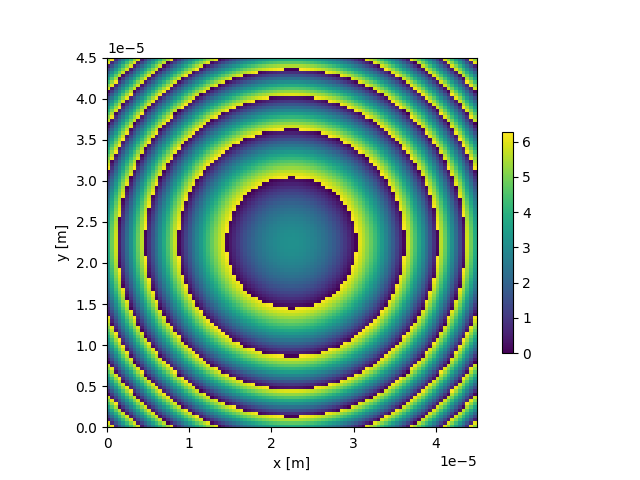

<IPython.core.display.Javascript object>


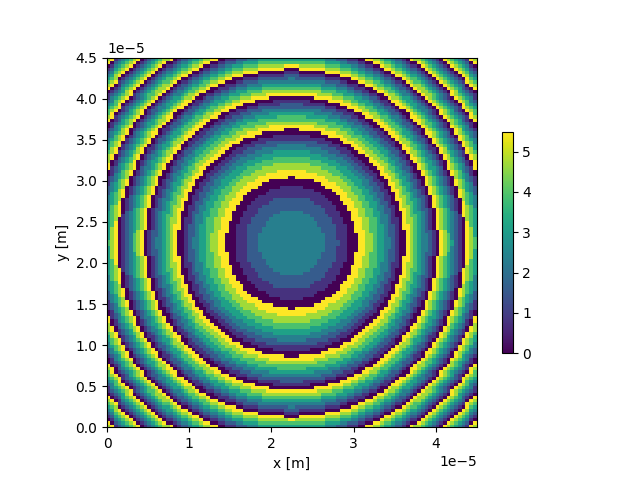

[Create Polygons]
Elapsed: 0:00:00.182695
Merging layer 0 of 7 with 1471 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.526041
Merging layer 1 of 7 with 1507 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.515041
Merging layer 2 of 7 with 1583 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.557420
Merging layer 3 of 7 with 1602 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.982455
Merging layer 4 of 7 with 1387 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.854065
Merging layer 5 of 7 with 1384 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.608044
Merging layer 6 of 7 with 1414 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.664940
Merging layer 7 of 7 with 1469 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:00.650049
[Total time converting to GDS]
Elapsed: 0:00:05.544749
Saved fresnel_phase_mask_hexagonal.gds
(117, 102)


<IPython.core.display.Javascript object>


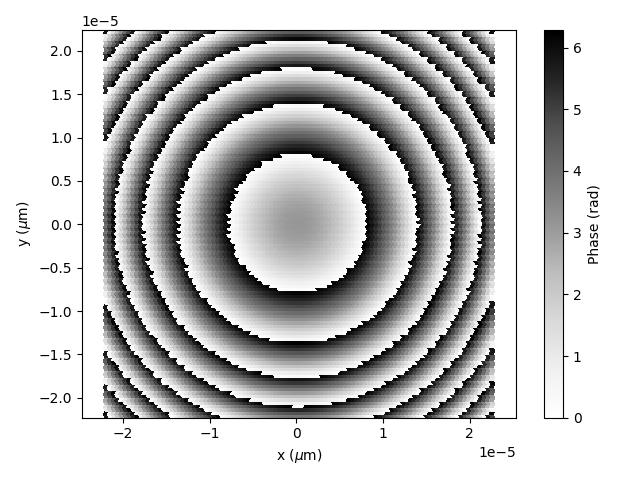

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(8,)


<IPython.core.display.Javascript object>


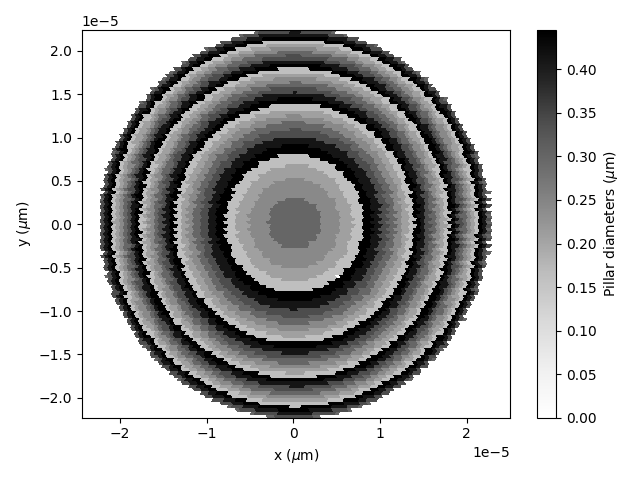

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [23]:
###Make a fresnel metasurface with hexagonal meshgrid 
foc = 100 # focal distance in um 
lda = 0.6328 #wavelength in um 
xsiz = 45 #um
ysiz = 45 #um
n = 8  # number of gray levels    
gdsname = 'fresnel_phase_mask_hexagonal.gds' # name of gds file
p=0.445
pixelx = p 
pixely =  p* np.cos(np.radians(30))

#calculation for the number of pixels using the size in x and the periodicity
npix_x = int(np.round(xsiz/pixelx)) 
npix_y = int(np.round(ysiz/pixely))

npix = npix_x * npix_y

# Create empty mask
aperture_hex = moe.generate.create_empty_aperture(0, xsiz*micro, npix_x, 0, ysiz*micro, npix_y,)

center = (xsiz*micro/2-pixelx*micro/2, ysiz*micro/2-pixely*micro/2)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture_hex, foc * micro, lda * micro, center = center)
moe.plotting.plot_aperture(mask, )

mask.discretize(n)
moe.plotting.plot_aperture(mask)

gdsmask = moe.GDSMask(mask, verbose=False)

# Create layout and merge polygons together
gdsmask.create_layout(mode = "raster", merge=True) # or mode ="contour"
gdsmask.write_gds(gdsname)

fresarray_rad = mask.aperture

###Create the hexagonal grid 
xv1, yv1 = np.meshgrid(np.arange(0, xsiz*micro, pixelx*micro), np.arange(0, ysiz*micro, pixely*micro))
xv1[::2, :] += pixelx*micro/2
xv = xv1 - center[0]
yv = yv1 - center[1]

#Calculate the fresnel phase at the hexagonal meshgrid points
fres_hex = moe.sag_functions.fresnel_lens_phase(xv,yv,foc*micro, lda*micro)

###transform the phase map into [0, 2*pi]
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas_hex = fres_hex

print(fres_hex.shape)

plt.figure()
plt.axis('equal')
plt.pcolormesh(xv,yv,fres_hex, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Phase (rad)')
plt.tight_layout()

#bins array, with n divisions, for the selection of points
#can be used in conjunction with the generate mask with exact selection of phase contours  - see Generate_masks.ipynb
binarray = np.linspace(0,2*np.pi,n)

#digitize the phase into the bins that we want 
#attention that the digitize function gives the INDEX of the value in the binarray 
newphas = np.digitize(fphas_hex, bins = binarray, right=True)

#initialize the  2D array of diameters 
diam_mat= fphas_hex

#To get the correspondent phase and also the diameter we do
for i, iv in enumerate(newphas): 
    for j, jv in enumerate(newphas[i,:]): 
        #get the phase corresponding to the digitization
        dphas = binarray[newphas[i,j] ] 
        #get the diameter from the interpolation function 
        #we clip to avoid the extrapolation at borders 
        diam_mat[i,j] = np.clip(func(dphas), 0, p) #np.clip(func(dphas ) , 0, p)
        ###truncate around radius

diam_mat[np.where(xv**2+yv**2>(xsiz*micro/2)**2)] = 0 
        
#check how many levels we actually have
print(np.shape(np.unique(diam_mat)))

dvarx_hex = diam_mat

plt.figure()
plt.axis('equal')
plt.pcolormesh(xv,yv,dvarx_hex, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()


In [24]:
###Transform the phase profile calculated in the square grid into a metasurface with square grid mask using instances 
topcellname = "TOP" #name of the gds cell 
outfile = "fresnel_metasurface_pillars_hexagonal.gds"

aperture_vals = fphas_hex
diam_mat = np.unique(dvarx_hex) 

moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfile, scaling= diam_mat, \
                       gdspyelements='pillar', verbose=False, grid='hex', mindim=0.2)

Pillar metasurface
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:00
Building meta-elements in layer 1:
Progress: [####################] 100.0%
Elapsed: 0:00:00.284017
Building meta-elements in layer 2:
Progress: [####################] 100.0%
Elapsed: 0:00:00.289309
Building meta-elements in layer 3:
Progress: [####################] 100.0%
Elapsed: 0:00:00.267019
Building meta-elements in layer 4:
Progress: [####################] 100.0%
Elapsed: 0:00:00.261020
Building meta-elements in layer 5:
Progress: [####################] 100.0%
Elapsed: 0:00:00.257017
Building meta-elements in layer 6:
Progress: [####################] 100.0%
Elapsed: 0:00:00.236019
Building meta-elements in layer 7:
Progress: [####################] 100.0%
Elapsed: 0:00:00.256019
Elapsed: 0:00:01.860427

 Saved the metasurface mask with 9270 meta-elements in the file fresnel_metasurface_pillars_hexagonal.gds


In [25]:
###Transform the phase profile calculated in the hexagonal grid into a metasurface with hexagonal grid mask using instances 
topcellname = "TOP" #name of the gds cell 
outfilen = "fresnel_metasurface_pillars_hexagonal_instances.gds"

aperture_vals = fphas_hex
diam_mat = np.unique(dvarx_hex) 
print(diam_mat)

moe.metas.metasurface_from_phase_instances (xsiz, ysiz, pixelx, pixely, p, aperture_vals, topcellname, outfilen, gdspyelements='pillar',\
                                  infile=None, verbose=False, rotation=None, scaling=diam_mat, grid='hex',\
                                      mindim = 0.05, smallerdim =0, tempfile="temp_inst.gds")


[0.         0.16324007 0.20856141 0.24309677 0.29948292 0.34043521
 0.4130154  0.445     ]
Pillar metasurface
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:00
Progress: [####################] 100.0%
So far 0 elements and counting.
Building meta-elements in layer 1:
Elapsed: 0:00:00.055001
Progress: [####################] 100.0%
So far 1334 elements and counting.
Building meta-elements in layer 2:
Elapsed: 0:00:00.065006
Progress: [####################] 100.0%
So far 2681 elements and counting.
Building meta-elements in layer 3:
Elapsed: 0:00:00.068006
Progress: [####################] 100.0%
So far 4021 elements and counting.
Building meta-elements in layer 4:
Elapsed: 0:00:00.064007
Progress: [####################] 100.0%
So far 5239 elements and counting.
Building meta-elements in layer 5:
Elapsed: 0:00:00.068006
Progress: [####################] 100.0%
So far 6575 elements and counting.
Building meta-elements in layer 6:
Elapsed: 0:00:

<IPython.core.display.Javascript object>


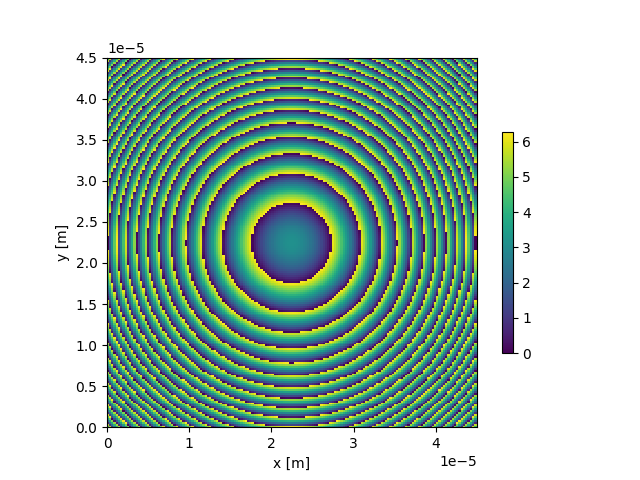

<IPython.core.display.Javascript object>


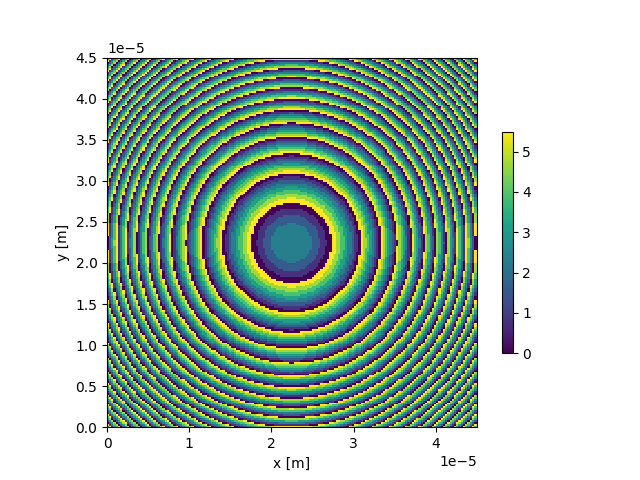

[Create Polygons]
Elapsed: 0:00:00.612475
Merging layer 0 of 7 with 4058 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.654758
Merging layer 1 of 7 with 4107 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.519377
Merging layer 2 of 7 with 4036 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.505673
Merging layer 3 of 7 with 4131 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.580154
Merging layer 4 of 7 with 3825 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.401685
Merging layer 5 of 7 with 3976 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.462868
Merging layer 6 of 7 with 3975 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.474157
Merging layer 7 of 7 with 3956 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:01.247446
[Total time converting to GDS]
Elapsed: 0:00:12.463596
Saved fresnel_phase_mask_triangles.gds
(193, 167)


<IPython.core.display.Javascript object>


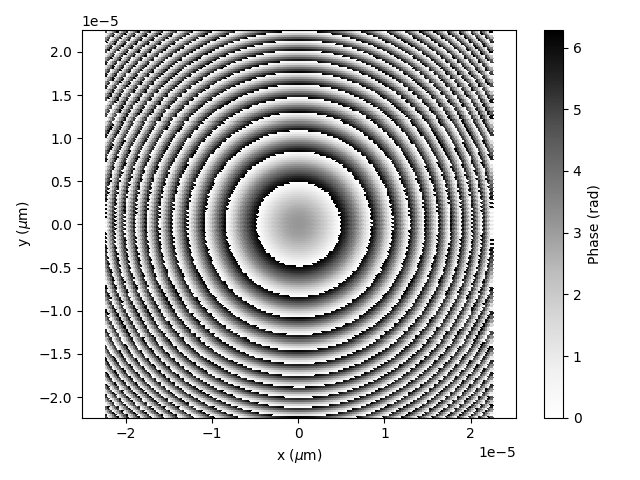

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(5,)


<IPython.core.display.Javascript object>


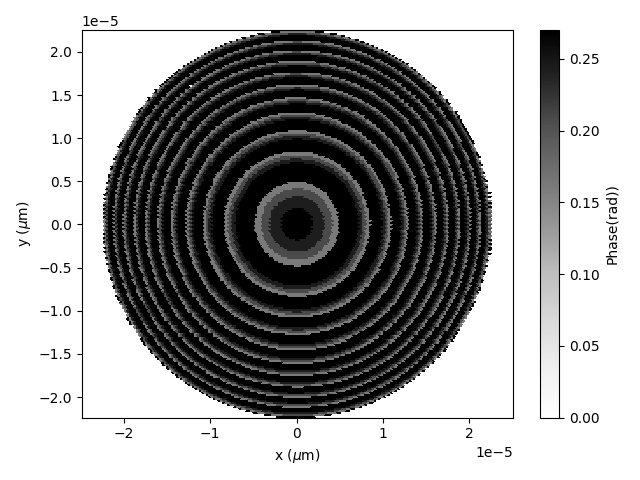

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [26]:
##reconstructing metalens in paper https://doi.org/10.1126/sciadv.abn5644 with hexagonal grid 

foc = 120 # focal distance in um 
lda = 0.197 #wavelength in um 
xsiz = 45 #um
ysiz = 45 #um
p=0.27
pixelx = p 
pixely =  p* np.cos(np.radians(30))

#calculation for the number of pixels using the size in x and the periodicity
npix_x = int(np.round(xsiz/pixelx)) 
npix_y = int(np.round(ysiz/pixely))

n = 8  # number of gray levels 
gdsname = 'fresnel_phase_mask_triangles.gds' # name of gds file

npix = npix_x * npix_y

# Create empty mask
aperture_hex = moe.generate.create_empty_aperture(0, xsiz*micro, npix_x, 0, ysiz*micro, npix_y,)

center = (xsiz*micro/2-pixelx*micro/2, ysiz*micro/2-pixely*micro/2)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture_hex, foc * micro, lda * micro, center = center)
moe.plotting.plot_aperture(mask, )

mask.discretize(n)
moe.plotting.plot_aperture(mask)

gdsmask = moe.GDSMask(mask, verbose=False)

# Create layout and merge polygons together
gdsmask.create_layout(mode = "raster", merge=True) # or mode ="contour"
gdsmask.write_gds(gdsname)

fresarray_rad = mask.aperture

###Create the hexagonal grid 
xv1, yv1 = np.meshgrid(np.arange(0, xsiz*micro, pixelx*micro), np.arange(0, ysiz*micro, pixely*micro))
xv1[::2, :] += pixelx*micro/2
xv = xv1 - center[0]
yv = yv1 - center[1]

#Calculate the fresnel phase at the hexagonal meshgrid points
fres_hex = moe.sag_functions.fresnel_lens_phase(xv,yv,foc*micro, lda*micro)

###transform the phase map into [0, 2*pi]
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas_hex = fres_hex

print(fres_hex.shape)

plt.figure()
plt.axis('equal')
plt.pcolormesh(xv,yv,fres_hex, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Phase (rad)')
plt.tight_layout()

#bins array, with n divisions, for the selection of points
#can be used in conjunction with the generate mask with exact selection of phase contours  - see Generate_masks.ipynb
binarray = np.linspace(0,2*np.pi,n)

#digitize the phase into the bins that we want 
#attention that the digitize function gives the INDEX of the value in the binarray 
newphas = np.digitize(fphas_hex, bins = binarray, right=True)

diam_mat= fphas_hex

#To get the correspondent phase and also the diameter we do
for i, iv in enumerate(newphas): 
    for j, jv in enumerate(newphas[i,:]): 
        #get the phase corresponding to the digitization
        dphas = binarray[newphas[i,j] ] 
        #get the diameter from the interpolation function 
        #we clip to avoid the extrapolation at borders 
        diam_mat[i,j] = np.clip(func(dphas), 0, p) #np.clip(func(dphas ) , 0, p)
        ###truncate around radius

diam_mat[np.where(xv**2+yv**2>(xsiz*micro/2)**2)] = 0 
        
#check how many levels we actually have
print(np.shape(np.unique(diam_mat)))

dvarx_hex = diam_mat

plt.figure()
plt.axis('equal')
plt.pcolormesh(xv,yv,dvarx_hex, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Phase(rad))')
plt.tight_layout()

In [27]:
##Hexagonal grid is being used 
topcellname = "TOP" #name of the gds cell 
p=0.27
outfilen = "fresnel_metasurface_triangular_hexagonal_instances.gds"
smallerdim =0  

aperture_vals2 =fres_hex
rotation_array = np.unique(diam_mat)


moe.metas.metasurface_from_phase_instances (xsiz, ysiz, pixelx, pixely, p, aperture_vals2, topcellname, outfilen, \
                                  infile="triangle.gds",verbose=False, rotation=rotation_array, scaling=None, grid='hex',\
                                  mindim = 0.05, smallerdim =0, tempfile="temptriangle2.gds")
 

Building the metasurface...
Total of 5 layers.
Building meta-elements in layer 0:
Rotated triangle.gds by 0.0 degrees. Saved in temptriangle2.gds
Elapsed: 0:00:00.156680
Progress: [####################] 100.0%
So far 7046 elements and counting.
Building meta-elements in layer 1:
Rotated triangle.gds by 9.35296693548882 degrees. Saved in temptriangle2.gds
Elapsed: 0:00:00.121007
Progress: [####################] 100.0%
So far 10775 elements and counting.
Building meta-elements in layer 2:
Rotated triangle.gds by 11.949688717515464 degrees. Saved in temptriangle2.gds
Elapsed: 0:00:00.112008
Progress: [####################] 100.0%
So far 14513 elements and counting.
Building meta-elements in layer 3:
Rotated triangle.gds by 13.928418988636588 degrees. Saved in temptriangle2.gds
Elapsed: 0:00:00.123010
Progress: [####################] 100.0%
So far 18223 elements and counting.
Building meta-elements in layer 4:
Rotated triangle.gds by 15.469860468532229 degrees. Saved in temptriangle2.gds
E

## Extra: Large metasurface with pre defined library (Yu et al. 2013)

../..\pyMOE\plotting.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


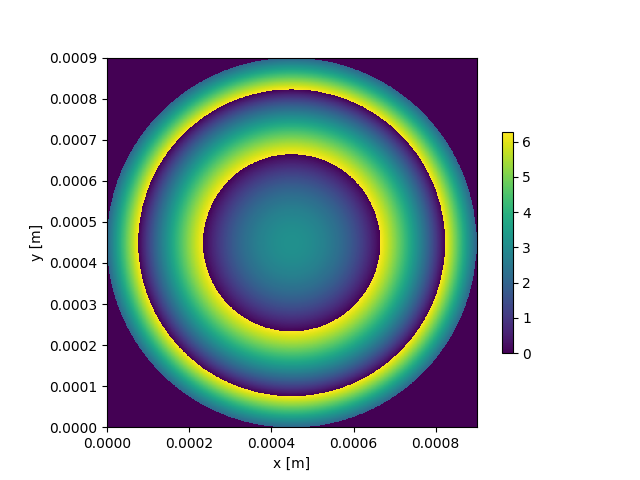

5.497772985431933


<IPython.core.display.Javascript object>


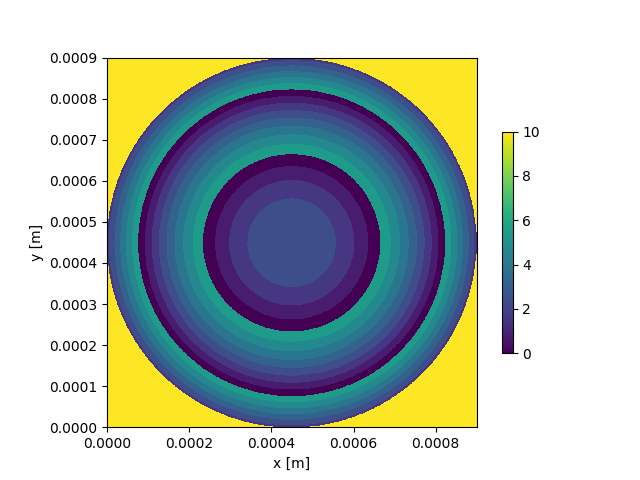

<IPython.core.display.Javascript object>


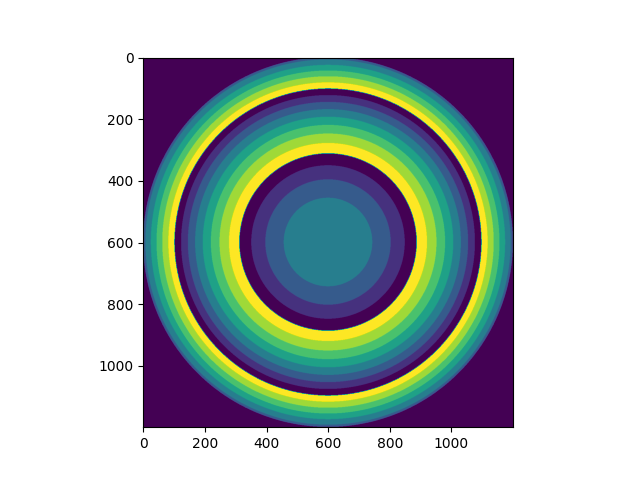

[Create Polygons]
Elapsed: 0:00:20.894255
Merging layer 0 of 7 with 440704 polygons:
Progress: [####################] 100.0%
Elapsed: 0:01:46.695491
Merging layer 1 of 7 with 129520 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:26.866971
Merging layer 2 of 7 with 156716 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:37.230963
Merging layer 3 of 7 with 194516 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:45.029663
Merging layer 4 of 7 with 129596 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:27.403442
Merging layer 5 of 7 with 129636 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:30.767174
Merging layer 6 of 7 with 129696 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:30.848377
Merging layer 7 of 7 with 129616 polygons:
Progress: [####################] 100.0%
Elapsed: 0:00:29.848673
[Total time converting to GDS]
Elapsed: 0:05:55.589011
Saved fresnel_phase_mask_yu_capasso.gds


In [28]:
###Reconstructing metalens of Yu et al. 2013, square grid 

foc = 30000 # focal distance in um 
lda = 1.55 #wavelength in um 
xsiz = 2*450 #um
ysiz = 2*450 #um
p=0.75
pixelx = p 
pixely = p 
n = 8  # number of gray levels 

#calculation for the number of pixels using the size in x and the periodicity
npix = int(np.round(xsiz/p))

# Create empty mask
aperture = moe.generate.create_empty_aperture(0, xsiz*micro, npix, 0, ysiz*micro, npix,)
center = (xsiz*micro/2, ysiz*micro/2)

# and truncate within radius
mask = moe.generate.fresnel_phase(aperture, foc * micro, lda * micro, radius=xsiz/2*micro, center = center, )
moe.plotting.plot_aperture(mask, )

mask.discretize(n)
print(np.max(mask.aperture))

mask2 = moe.generate.truncate_aperture_radius(mask, radius =xsiz/2*micro, center=center, truncate_value=10)
moe.plotting.plot_aperture(mask2,)

mask2.discretize(n)

fig = plt.figure()
plt.imshow(mask2.aperture)

gdsmask = moe.GDSMask(mask, verbose=False)
gdsname = 'fresnel_phase_mask_yu_capasso.gds' # name of gds file
# Create layout and merge polygons together
gdsmask.create_layout(mode = "raster", merge=True) # or mode ="contour"
gdsmask.write_gds(gdsname)
 
    
width = 0.05 #um 
lengtharray = np.array([0.085,0.18,0.14,0.13])  #um
deltas = np.array([175,  79,68, 104 ]) #degs
angles = np.array([-45, 225]) #degs
elements= [] 

nindex =0
for angle in angles: 
    for il, delta in enumerate(deltas): 
        elements = np.append(yu_capasso_library_element(cellname, width, lengtharray[il], delta, angle,  nind=nindex, save=True), elements)

        nindex = nindex + 1 
        
        
##organize the meta-elements to match the reported phases in fig 16
elements = np.flip(elements)
gdspyelementarray = [elements[4], elements[5], elements[6], elements[7], elements[0], elements[1], elements[2], elements[3] ]




In [29]:
#Build the metasurface 
topcellname = "TOP" #name of the gds cell 
outfile  = "fresnel_metasurface_yu_capasso.gds"

moe.metas.metasurface_from_phase(xsiz, ysiz, pixelx, pixely, p, mask2.aperture, topcellname, outfile, rotation=None,\
                       scaling= None, gdspyelements=gdspyelementarray, verbose=False, grid='square', largest_phase=np.max(mask.aperture) )

Custom metasurface
8
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Progress: [####################] 100.0%
Elapsed: 0:01:03.678773
Building meta-elements in layer 1:
Progress: [####################] 100.0%
Elapsed: 0:00:17.523681
Building meta-elements in layer 2:
Progress: [####################] 100.0%
Elapsed: 0:00:22.298908
Building meta-elements in layer 3:
Progress: [####################] 100.0%
Elapsed: 0:00:29.229383
Building meta-elements in layer 4:
Progress: [####################] 100.0%
Elapsed: 0:00:18.242900
Building meta-elements in layer 5:
Progress: [####################] 100.0%
Elapsed: 0:00:20.224581
Building meta-elements in layer 6:
Progress: [####################] 100.0%
Elapsed: 0:00:19.643781
Building meta-elements in layer 7:
Progress: [####################] 100.0%
Elapsed: 0:00:18.085940
Elapsed: 0:03:29.017952

 Saved the metasurface mask with 1440000 meta-elements in the file fresnel_metasurface_yu_capasso.gds


In [30]:
outfile2  = "fresnel_metasurface_yu_capasso_instances.gds"
moe.metas.metasurface_from_phase_instances(xsiz, ysiz, pixelx, pixely, p, mask2.aperture, topcellname, outfile2,\
                                           gdspyelements=gdspyelementarray, infile=None, verbose=False, rotation=None, \
                                           scaling=None, grid='square',tempfile="tem_inst.gds", \
                                           largest_phase=np.max(mask.aperture) )

Custom metasurface
8
Building the metasurface...
Total of 8 layers.
Building meta-elements in layer 0:
Elapsed: 0:00:08.580164
Progress: [####################] 100.0%
So far 440704 elements and counting.
Building meta-elements in layer 1:
Elapsed: 0:00:03.536092
Progress: [####################] 100.0%
So far 570224 elements and counting.
Building meta-elements in layer 2:
Elapsed: 0:00:04.215631
Progress: [####################] 100.0%
So far 726940 elements and counting.
Building meta-elements in layer 3:
Elapsed: 0:00:04.879097
Progress: [####################] 100.0%
So far 921456 elements and counting.
Building meta-elements in layer 4:
Elapsed: 0:00:04.124180
Progress: [####################] 100.0%
So far 1051052 elements and counting.
Building meta-elements in layer 5:
Elapsed: 0:00:03.722871
Progress: [####################] 100.0%
So far 1180688 elements and counting.
Building meta-elements in layer 6:
Elapsed: 0:00:03.611138
Progress: [####################] 100.0%
So far 1310384 

## Extra: merge layers in .gds metasurface file

In [31]:
import pyMOE.gds_klops as gdsops

#take inputfile as the previous big metasurface with instantiated cells 
inputfile = "fresnel_metasurface_yu_capasso_instances.gds"
outputfile = "fresnel_metasurface_yu_capasso_instances_merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile, cellname, layer, datatype ,outputfile )


#take inputfile as the previous big metasurface 
inputfile = "fresnel_metasurface_yu_capasso.gds"
outputfile = "fresnel_metasurface_yu_capasso_merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile, cellname, layer, datatype ,outputfile )


####The final filesize is the exactly the same for instantiated and non instantiated 

Merged layers in fresnel_metasurface_yu_capasso_instances_merged.gds
Merged layers in fresnel_metasurface_yu_capasso_merged.gds


As a final note: for mask generation, and to understand where the elements are positioned within the layer, using instantiation is much faster, clean and results in smaller filesizes. However, when flattening and merging, both instantiated and non-instantiated files result in same filesize.